In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [302]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position =  1 / fcen 
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [303]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=design_variables,
        size=mp.Vector3(design_region_width, design_region_height, 0),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [304]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )


sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [305]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

def mapping(x, eta, beta):

    return x

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


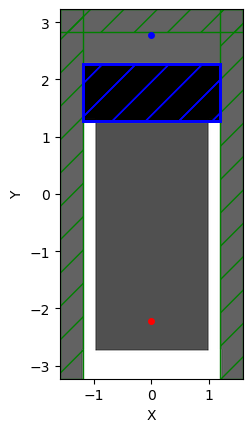

In [307]:
monitor_position_J, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position_J,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)

opt.plot2D(True)

In [308]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [309]:
evaluation_history_adam = []
beta_history = []

cur_iter = [0]

numevl = 1

lr_history=[]

uf_history=[]
t_history=[]
adjgrad_history=[]
lr_history = []

optimizer = AdamOptimizer(lr=0.02, beta1=0.9)

def f(v,eta, cur_beta):
    global numevl
    print("Current iteration: {}".format(cur_iter[0] + 1))
    
    f0_r, dJ_du0 = opt([v])
    
    f0=np.array([np.real(f0_r)])
    
    if v.size > 0:
        gradient0 = v*0
    
        gradient0[:] = dJ_du0

        gradient=gradient0
        
        adjgrad_norm = gradient.mean()
        adjgrad_history.append(adjgrad_norm) 

        # Optimize design
        updated_x, adam_lr, adam_uf, adam_m, adam_v, adam_t = optimizer.update(v, gradient)
        
        cur_beta= cur_beta+ npa.tanh((cur_beta-0.5)*0.01)
        evaluation_history_adam.append(f0_r)
        beta_history.append(cur_beta)
        cur_iter[0] = cur_iter[0] + 1
        lr_history.append(adam_lr)
        uf_history.append(adam_uf)
        t_history.append(adam_t)
        
        print("Current FoM0: {}".format(np.real(f0)))
        print("Current_beta:{}".format(cur_beta))
        
        return updated_x, adam_m, adam_v, cur_beta

In [310]:
total_iter = 50
cur_beta=1
n=Nx*Ny
x=np.ones(n)*0.5

for iters in range(total_iter):
    x, adam_m, adam_v, cur_beta = f(x,eta_i,cur_beta)

Current iteration: 1
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.79086e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.46 x 0 with resolution 50
     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.06567 s
time for set_c

# FOM이 떨어지는 지점에서 beta 값이 수정되는건지?
# Multi layer 

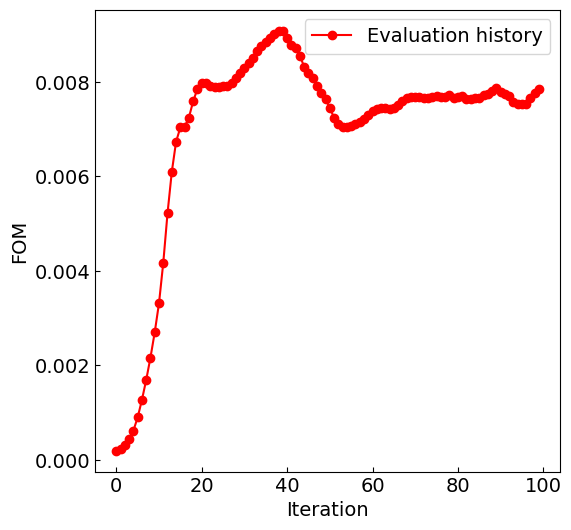

In [311]:
plt.figure(figsize = (6,6))

plt.plot(evaluation_history_adam, 'or-',   label='Evaluation history',)

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# plt.title('Optimization', fontsize = 16)
plt.tick_params(direction = 'in')

plt.legend( fontsize = 14,)

plt.show()

In [135]:
max(evaluation_history_adam)

0.00908701025236608

In [ ]:
# np.savetxt("adam_weights_2lambda_pos_new_objf.txt", design_variables.weights)

In [314]:
np.savetxt("adam_weights_1lambda_pos_new_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_2lambda_pos.txt", design_variables.weights)

In [315]:
import numpy as np

data = np.loadtxt('adam_weights_1lambda_pos_new_objf.txt')

print("Loaded array shape:", data.shape)

opt.update_design([data])
# data


Loaded array shape: (6171,)


In [109]:
# adam_iter100 = design_variables.weights

In [110]:
# opt.update_design([adam_iter100])

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     

block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


(-1.2, 1.2, 1.27, 2.27)

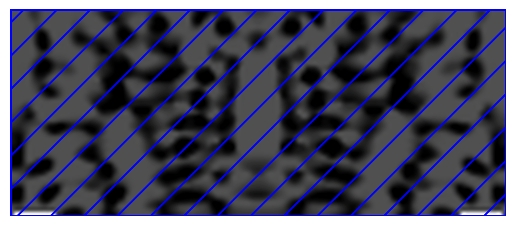

In [403]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

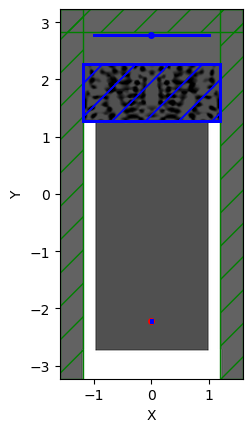

In [404]:
r1 = 1.22 * (1/fcen * monitor_position) / design_region_width
diameter = 2 * r1

offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
                # weight=-1
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()


-----------
Initializing structure...
time for choose_chunkdivision = 3.8147e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.46 x 0 with resolution 50
     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0596502 s
time for set_conductivity = 0.00217605 s
time for set_cond

<Axes: xlabel='X', ylabel='Y'>

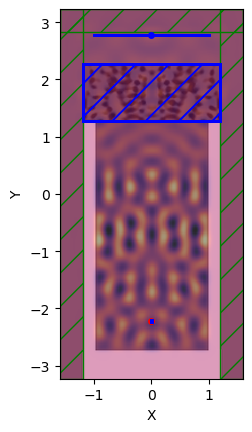

In [405]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources.center, 1e-3))

opt.sim.plot2D(fields = mp.Ez, 
            #    output_plane=mp.Volume(
            #         center = monitor_position_y,
            #         size = mp.Vector3(2, 1)
            #     ),
    field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 0.5,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


<Axes: xlabel='X', ylabel='Y'>

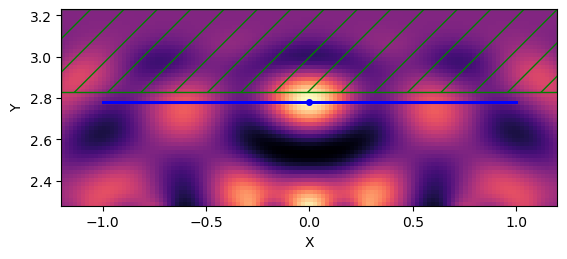

In [406]:
opt.sim.plot2D(fields = mp.Ez, 
               output_plane=mp.Volume(
                    center = monitor_position_y,
                    size = mp.Vector3(2.4, 1)
                ),
    field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 1,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


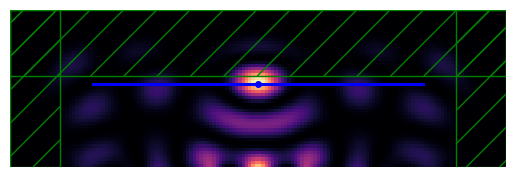

In [407]:
opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

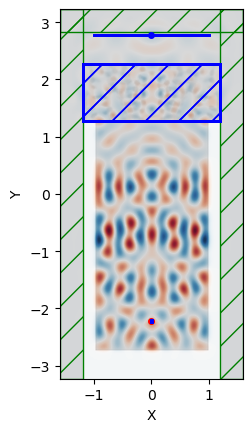

In [408]:
opt.sim.plot2D(fields = mp.Ez)

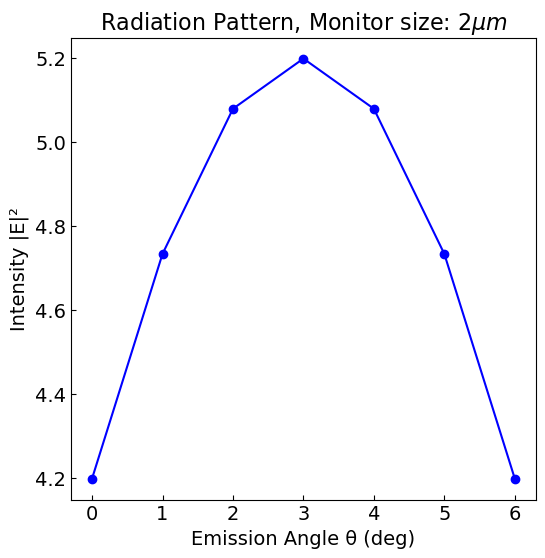

In [392]:
external_field_array = opt.sim.get_dft_array(dft_fields, mp.Ez, 0)
# external_field_array = mp.get_fluxes(out_flux)

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리
theta = np.degrees(np.arctan2(x, z))               # rad → deg 변환

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot( I, 'bo-')
plt.xlabel('Emission Angle θ (deg)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
plt.title(r'Radiation Pattern, Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [415]:
1/fcen*1/fcen

0.25917355371900824

In [414]:
1.22 * (1/fcen*1/fcen)/design_region_width * 2

0.26349311294765837

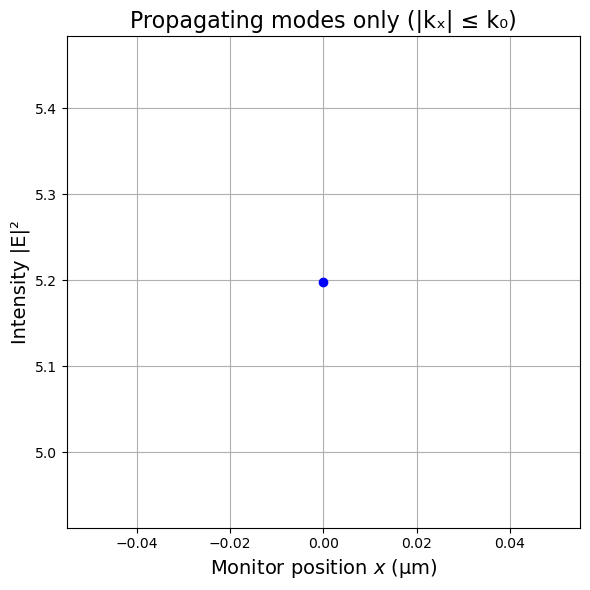

In [391]:
import numpy as np
import matplotlib.pyplot as plt

# ——— 1) 시뮬레이션 데이터 & 기본 변수 ———
external_field_array = sim.get_dft_array(dft_fields, mp.Ez, 0)  # E(x) at the monitor
I  = np.abs(external_field_array)**2
N  = len(external_field_array)
W  = mn_size                            # monitor 폭 (µm)
x  = np.linspace(-W/2, W/2, N)         # monitor 상의 위치 (µm)
dx = x[1] - x[0]                        # 샘플 간격 (µm)
lambda_ = 1/fcen                        # 파장 (µm)
k0 = 2 * np.pi / lambda_                # 진공 파수 (rad/µm)

# ——— 2) kₓ 스펙트럼 계산 ———
E_k     = np.fft.fftshift(np.fft.fft(external_field_array)) / N
kx_cyc  = np.fft.fftshift(np.fft.fftfreq(N, d=dx))    # cycle/µm
kx      = 2 * np.pi * kx_cyc                         # rad/µm

# ——— 3) mask: 전파 모드만 (|kₓ| ≤ k₀) ———
mask    = np.abs(kx) <= k0

# mask 적용: 위치 x, 강도 I 만 남김
x_prop  = x[mask]
I_prop  = I[mask]

# ——— 4) 모니터 위치(x) 축으로 플롯 ———
plt.figure(figsize=(6,6))
plt.plot(x_prop, I_prop, 'bo-')
plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
plt.title('Propagating modes only (|kₓ| ≤ k₀)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [373]:
import numpy as np
import matplotlib.pyplot as plt

# ——— 1) 시뮬레이션 데이터 & 기본 변수 ———
E_x    = sim.get_dft_array(dft_fields, mp.Ez, 0)    # 변수 이름을 E_x로 통일
I      = np.abs(E_x)**2
N      = len(E_x)
W      = mn_size                                    # µm
x      = np.linspace(-W/2, W/2, N)                  # µm
dx     = x[1] - x[0]
lambda_ = 1/fcen                                    # µm
k0     = 2 * np.pi / lambda_                        # rad/µm

# ——— 2) kₓ 스펙트럼 계산 ———
E_k    = np.fft.fftshift(np.fft.fft(E_x)) / N
kx     = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# ——— 3) mask: 전파 모드만 (|kₓ| ≤ k₀) ———
mask   = np.abs(kx) <= k0

# ——— 4) k-space에서 flux 적분 ———
dkx         = kx[1] - kx[0]
flux_k      = np.abs(E_k)**2
output_flux = np.sum(flux_k[mask]) * dkx

print(f"Output flux (propagating modes) = {output_flux:.5f}")


Output flux (propagating modes) = 1.90164


In [ ]:
# 1) propagating 모드만 남기고 IFFT (이전 코드와 동일)
E_k_prop    = E_k.copy()
E_k_prop[~mask] = 0
E_prop      = np.fft.ifft(np.fft.ifftshift(E_k_prop)) * N

# 2) real-space intensity & flux 적분
I_prop      = np.abs(E_prop)**2
output_flux = np.trapz(I_prop, x)
output_flux

1.2289938070036943

In [375]:
freq_idx = 0

Ez_hat = sim.get_dft_array(dft_fields, mp.Ez, freq_idx)  
Hx_hat = sim.get_dft_array(dft_fields, mp.Hx, freq_idx)  

Sy_density = np.real(Ez_hat * np.conj(Hx_hat))   

L = float(monitor_size.x)      
N = Sy_density.size            
x = np.linspace(-L/2, L/2, N)  

flux_total = np.round(np.trapz(Sy_density, x)  ,5)
add_flx = np.array(mp.get_fluxes(out_flux))[0]

print(f"DFT monitor 적분으로 구한 total flux = {flux_total}")
print("Add flux로 계산한 total flux = ", add_flx)

err = np.abs((flux_total-add_flx)/add_flx)*100
print("오차율 (%) : ", err, "%\n")

# eqe = np.round(add_flx / np.array(mp.get_fluxes(input_flux))[0] * 100,5)
eqe = output_flux/mp.get_fluxes(input_flux)[0]
print("Output flux :", output_flux)
# print("Input flux :", np.round(np.array(mp.get_fluxes(input_flux))[0] ,5))
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("EQE(%) :", eqe,"%")

DFT monitor 적분으로 구한 total flux = 1.00005
Add flux로 계산한 total flux =  0.9962678475671026
오차율 (%) :  0.37963208811099725 %

Output flux : 1.901638926588627
Input flux : 0.9370841942834123
EQE(%) : 2.0293149091505156 %


In [396]:
# eqe = np.round(add_flx / np.array(mp.get_fluxes(input_flux))[0] * 100,5)
eqe =np.array(mp.get_fluxes(out_flux))/mp.get_fluxes(input_flux)[0] * 100
print("Output flux :", mp.get_fluxes(out_flux))
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("EQE(%) :", eqe,"%")

Output flux : [0.4361806820070876]
Input flux : 0.9370841942834123
EQE(%) : [46.54658404] %


In [333]:
print(mp.get_fluxes(input_flux)[0])
print(mp.get_fluxes(out_flux)[0])

0.9370841942834123
0.7765094039280138
